### find DRO solutions by minimization
find initial conditions: find minimum distance after 1 year to find exact initial conditions for given subsolar distance of the DRO

fix: 365 days right now, not 365.24 days

note that there are e.g. orbits that come back to Earth after 2 years 


---
### Issues
- algorithm for search for initial conditions: fix 365 to 365.24 days - move to find_dro.ipynb

In [1]:
import time
import os
import requests
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import pickle
import spiceypy
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy import stats
from scipy.signal import argrelextrema
import multiprocessing as mp

import astropy.units as u
from astropy import constants as const

au=const.au.value*1e-3
M_sun = const.M_sun.value  # Sun mass
M_earth = const.M_earth.value   # Earth mass
G=const.G.value*1e-9 # use km
# Sun-Earth system parameters mu: mass parameter (m2/(m1+m2))
mu = M_earth/(M_sun+M_earth)  # Earth mass / (Sun + Earth mass)

# Calculate system parameters
M_total = M_sun + M_earth
omega = np.sqrt(G * M_total / au**3)  # Angular velocity of rotating frame (rad/s) from keplers laws?


print('Au in km:',au) # in km
print('M sun',M_sun)
print('M earth',M_earth)
print('G:',G)

print(f"System Parameters:")
print(f"  Mass parameter μ = {mu:.6e}")
print(f"  Earth-Sun distance au = {au:.6e} km")
print(f"  Angular velocity ω = {omega:.6e} rad/s")
print(f"  Orbital period = {2*np.pi/omega/86400:.2f} days\n")


#plotly if needed
#import plotly.graph_objects as go
#from plotly.offline import iplot, init_notebook_mode
#from plotly.subplots import make_subplots
#import plotly.io as pio
#import plotly.express as px
#pio.renderers.default = 'browser'

kernels_path='kernels'

#make sure to convert the current notebook to a script if you want to run it on a server
os.system('jupyter nbconvert --to script find_dro.ipynb')   


Au in km: 149597870.70000002
M sun 1.988409870698051e+30
M earth 5.972167867791379e+24
G: 6.6743e-20
System Parameters:
  Mass parameter μ = 3.003480e-06
  Earth-Sun distance au = 1.495979e+08 km
  Angular velocity ω = 1.990987e-07 rad/s
  Orbital period = 365.26 days



[NbConvertApp] Converting notebook find_dro.ipynb to script
[NbConvertApp] Writing 4620 bytes to find_dro.py


0

In [2]:
def cr3bp_equations(t, state):
    """
    Equations of motion for the Circular Restricted 3-Body Problem
    in the rotating reference frame with physical units.    
    state = [x, y, vx, vy] in km and km/s
    """
    x, y, vx, vy = state
    
    # Positions of the primaries in rotating frame
    x1 = -mu * au  # Sun position
    x2 = (1 - mu) * au  # Earth position
    
    # Distances to the two primaries
    r1 = np.sqrt((x - x1)**2 + y**2)
    r2 = np.sqrt((x - x2)**2 + y**2)
    
    # need to check these equations with Frnka 2010
    ax = (2*omega*vy + omega**2*x - G*M_sun*(x - x1)/r1**3 - G*M_earth*(x - x2)/r2**3)    
    ay = (-2*omega*vx + omega**2*y - G*M_sun*y/r1**3 - G*M_earth*y/r2**3)
    
    return [vx, vy, ax, ay]


def make_dro(initial_state,years):

    days = 365*years  # Simulate for n years
    t_span = (0, days * 86400)      # Time span for integration (in seconds)
    t_eval = np.linspace(t_span[0], t_span[1], days*24) #time resolution is 1 hour, need to include better for arbitrary time arrays

    #print("Integration started")
    # Solve the differential equations
    solution = solve_ivp(cr3bp_equations, t_span, initial_state,  t_eval=t_eval, method='DOP853', rtol=1e-10, atol=1e-8)

    # Extract trajectory, convert to au
    x = solution.y[0]/au; y = solution.y[1]/au

    #print("Integration done")
    
    return x,y


indices  [30]
vy0 [km/s] values for all minima [6.06060606]


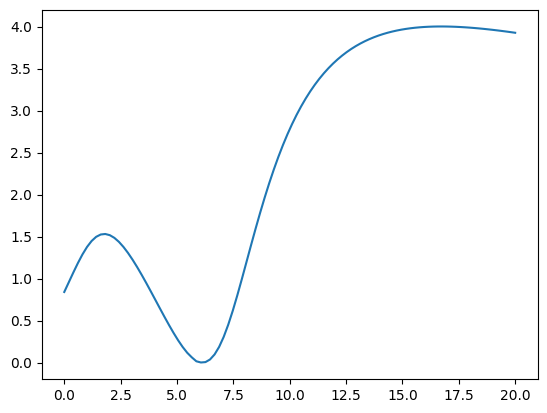

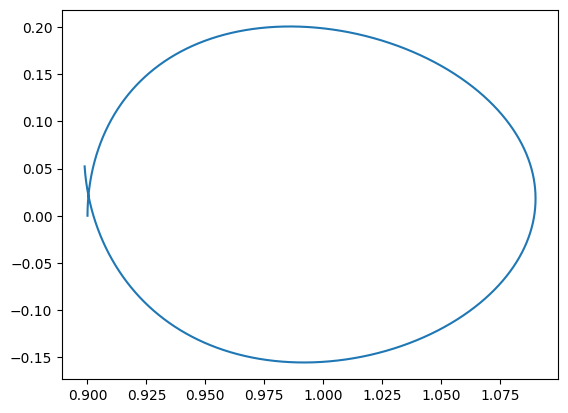

In [3]:


########### start with subsolar distance of the DRO you want to find
x0 = 0.9*au  # km (between Sun and Earth)
y0 = 0
vx0 = 0

#array of initial speed in y direction
resolution=100 #50-200

#retrograde orbits start with positive vy
vy0_arr=np.linspace(0.0,20.0,resolution)

#prograde check
#vy0_arr=-np.linspace(0.0,20.0,resolution)


distance=[]
#go through all orbit solutions for given 
for i in np.arange(0,len(vy0_arr),1):    
    [xtest,ytest]=make_dro([x0, y0, vx0, vy0_arr[i]],1)
    distance.append(np.linalg.norm([xtest[-1]-x0/au],[ytest[-1]-y0/au]))

distance=np.array(distance)
plt.figure(2)
plt.plot(vy0_arr,distance)  

#find all minima of distance for different orbits that close in on themselves
min_i = argrelextrema(distance, np.less)[0]
print('indices ',min_i)
print('vy0 [km/s] values for all minima',vy0_arr[min_i])

### plot all solutions that close in on themselves
plt.figure(3)
for k in np.arange(0,len(min_i)):
    [xmini,ymini]=make_dro([x0, y0, vx0, vy0_arr[min_i[k]]],1)
    plt.plot(xmini,ymini)

